<a href="https://colab.research.google.com/github/prairie-dogY/test/blob/main/DL_%E7%AB%A0%E6%9C%AB%E5%95%8F%E9%A1%8C(%E3%83%95%E3%82%A1%E3%82%A4%E3%83%B3%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E6%9C%89).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/dog_cat_data.zip
!pip install -q torchmetrics==0.11.4 pytorch_lightning==2.0.2
!pip install pytorch_lightning
!pip install torchmetrics

Archive:  /content/drive/MyDrive/dog_cat_data.zip
replace __MACOSX/._dog_cat_data? [y]es, [n]o, [A]ll, [N]one, [r]ename: ERROR: Operation cancelled by user


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger

from torchvision import transforms,datasets

from PIL import Image

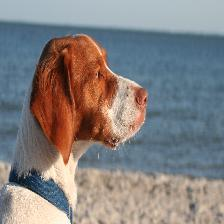

In [ ]:
path = '/content/dog_cat_data/train/dog/0.jpg'
img = Image.open(path).convert('RGB')
img

In [ ]:
#前処理
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std = [0.229,0.224,0.225])
])

In [ ]:
#前処理とアノテーション
dataset = datasets.ImageFolder('/content/dog_cat_data/train', transform )
dataset

Dataset ImageFolder
    Number of datapoints: 300
    Root location: /content/dog_cat_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
len(dataset)

300

In [ ]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0667, 0.0549, 0.0392],
          [0.0000, 0.0000, 0.0000,  ..., 0.0863, 0.0784, 0.0706],
          [0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.0824, 0.0863],
          ...,
          [0.6824, 0.6275, 0.7020,  ..., 0.5961, 0.7451, 0.4549],
          [0.5961, 0.6431, 0.6392,  ..., 0.5686, 0.6784, 0.7255],
          [0.6039, 0.7569, 0.5843,  ..., 0.7098, 0.7098, 0.7373]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0118, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0353, 0.0275],
          [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0275, 0.0314],
          ...,
          [0.4980, 0.4431, 0.5176,  ..., 0.4118, 0.5608, 0.2706],
          [0.4118, 0.4588, 0.4549,  ..., 0.3843, 0.4941, 0.5412],
          [0.4196, 0.5725, 0.4000,  ..., 0.5255, 0.5255, 0.5529]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0196, 0.0118],
          [0.0000, 0.0000, 0.0000,  ...,

In [ ]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
from torchvision.models import resnet18

In [ ]:
# 乱数の固定
pl.seed_everything(0)
#バッチサイズの定義
batch_size = 10

# データの分割
train_dataset, val_dataset =torch.utils.data.random_split(dataset, [250, 50])

# DataLoaderの作成
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
class Net(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.feature = resnet18(pretrained=True)
    self.fc = nn.Linear(1000, 2)
    # self.out_chanels = 4 #out_channels
    # self.calc = self.out_chanels * 112 * 112 #アウトチャンネルに対する計算

    # self.batch_size = 10
    # self.conv = nn.Conv2d(in_channels=3, out_channels=self.out_chanels, kernel_size=3, padding=1)
    # self.bn = nn.BatchNorm2d(self.out_chanels)
    # # self.bn1 = nn.BatchNorm2d(25088)
    # self.fc1 =nn.Linear(self.calc,2)
    # # self.fc2 = nn.Linear(25088,2)

  def forward(self,x):
    h = self.feature(x)
    h = self.fc(h)
    # h = self.conv(x)
    # h = F.relu(h)
    # h = self.bn(h)
    # h = F.max_pool2d(h, kernel_size=2, stride=2)
    # h = h.view(-1,self.calc)
    # h = self.fc1(h)
    # # h = F.relu(h)
    # # h = self.bn1(h)
    # # h = F.max_pool2d(h, kernel_size=2, stride=2)
    # # h = self.fc2(h)
    return(h)

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
     x, t = batch
     y = self(x)
     loss = F.cross_entropy(y, t)
     self.log('test_loss', loss, on_step=False, on_epoch=True)
     self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
     return loss

  def configure_optimizers(self):
     optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
     return optimizer




In [ ]:
#アーキテクチャの確認
# summary(net, input_size=(3,224,224))

NameError: name 'net' is not defined

In [ ]:
# 学習の実行]
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir="logs",name='my_exp')
trainer = pl.Trainer(max_epochs=10, accelerator="cpu", deterministic=False,logger=logger)
trainer.fit(net, train_loader,val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my_exp/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | feature | ResNet | 11.7 M
1 | fc      | Linear | 2.0 K 
-----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.766    Total estimated model params size (MB)
/usr/local/lib/pytho

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
#学習の確認
trainer.callback_metrics

{'train_loss': tensor(0.0210),
 'train_loss_step': tensor(0.0083),
 'train_acc': tensor(1.),
 'train_acc_step': tensor(1.),
 'val_loss': tensor(0.0210),
 'val_acc': tensor(1.),
 'train_loss_epoch': tensor(0.0210),
 'train_acc_epoch': tensor(1.)}

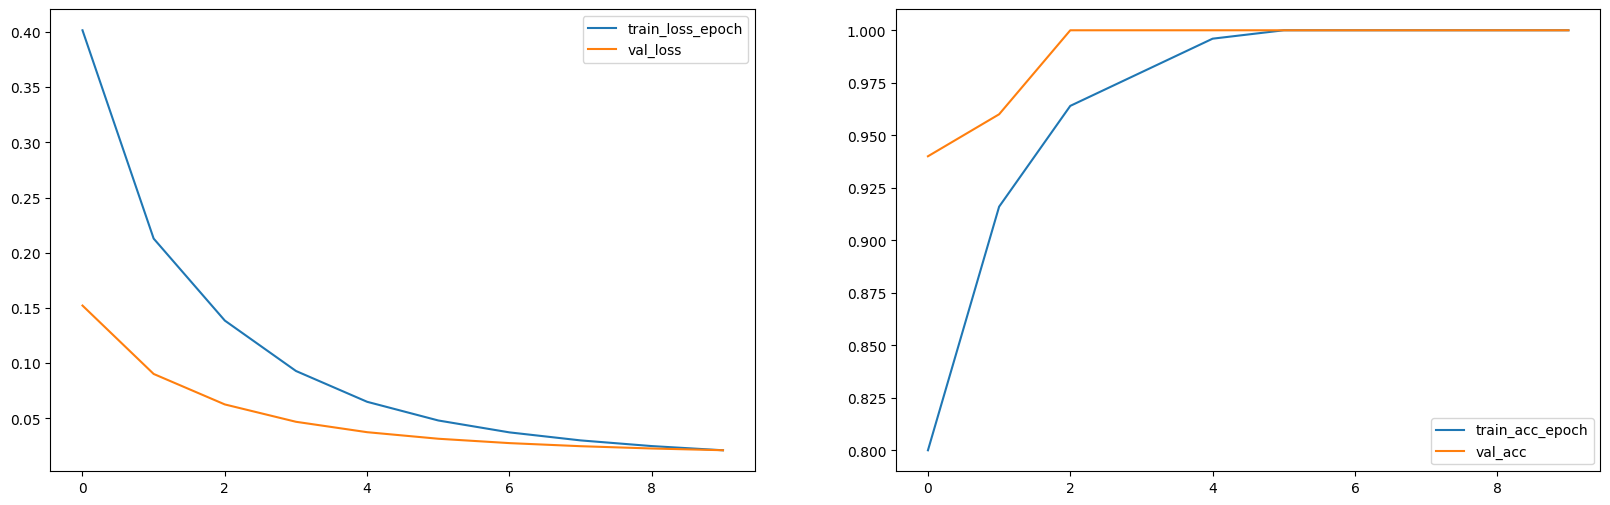

In [ ]:
# 学習ログの取得
log = pd.read_csv('/content/logs/my_exp/version_0/metrics.csv')
plt.figure(figsize=(20,6))

#loss
plt.subplot(1,2,1)
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();
plt.legend()

#accracy
plt.subplot(1,2,2)
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();
plt.legend()

In [ ]:
# 学習済みモデルの保存
torch.save(net.state_dict(), 'dog_cat.pt')

In [ ]:
# ネットワークの準備
net = Net().cpu().eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 重みの読み込み
net.load_state_dict(torch.load('dog_cat.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

推論時の前処理

In [ ]:
#前処理とアノテーション
dataset_test = datasets.ImageFolder('/content/dog_cat_data/train', transform )

In [ ]:
from glob import glob
from natsort import natsorted

In [ ]:
paths = natsorted(glob('/content/dog_cat_data/test/*.jpg'))

In [ ]:
len(paths)

200

In [ ]:
paths[:10]

['/content/dog_cat_data/test/0.jpg',
 '/content/dog_cat_data/test/1.jpg',
 '/content/dog_cat_data/test/2.jpg',
 '/content/dog_cat_data/test/3.jpg',
 '/content/dog_cat_data/test/4.jpg',
 '/content/dog_cat_data/test/5.jpg',
 '/content/dog_cat_data/test/6.jpg',
 '/content/dog_cat_data/test/7.jpg',
 '/content/dog_cat_data/test/8.jpg',
 '/content/dog_cat_data/test/9.jpg']

In [ ]:
imgs = []
for path in paths:
  img = Image.open(path)
  imgs.append(transform(img))

In [ ]:
len(imgs)

200

In [ ]:
imgs[0]

tensor([[[ 0.7762,  0.6392,  0.5364,  ...,  1.5468,  1.5639,  1.5639],
         [ 0.8276,  0.7248,  0.6563,  ...,  1.5297,  1.5468,  1.5639],
         [ 0.6563,  0.6049,  0.5878,  ...,  1.4954,  1.5125,  1.5297],
         ...,
         [ 0.9303,  0.8618,  0.8447,  ..., -0.4054, -0.2856, -0.1828],
         [ 0.9132,  0.8961,  0.9474,  ..., -0.3883, -0.3027, -0.2171],
         [ 0.7762,  0.8104,  0.8789,  ..., -0.4226, -0.3712, -0.3198]],

        [[ 0.9580,  0.8179,  0.7129,  ...,  1.7283,  1.7458,  1.7458],
         [ 1.0105,  0.9055,  0.8354,  ...,  1.7108,  1.7283,  1.7458],
         [ 0.8354,  0.7829,  0.7654,  ...,  1.6758,  1.6933,  1.7108],
         ...,
         [ 1.3431,  1.2731,  1.2556,  ..., -0.1625, -0.0399,  0.0651],
         [ 1.3256,  1.3081,  1.3606,  ..., -0.1625, -0.0399,  0.0476],
         [ 1.1856,  1.2206,  1.2906,  ..., -0.1975, -0.1099, -0.0574]],

        [[ 1.0888,  0.9494,  0.8448,  ...,  1.8557,  1.8731,  1.8731],
         [ 1.1411,  1.0365,  0.9668,  ...,  1

In [ ]:
# prompt: 上で作成した'dog_cat.pt'の学習済みモデルを使ってimgsのデータの分類を行いたいです。

# 推論
net.eval()
with torch.no_grad():
  outputs = net(torch.stack(imgs))
  _, predicted = torch.max(outputs, 1)
  print(predicted)


tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0])


In [ ]:
# prompt: 上のpredictedの結果をpd.Series(y, name=‘class’).to_csv(‘submission.csv’, index=None, line_terminator='\n')のコードを適用してcsvに出力したいです

import pandas as pd
y = predicted.numpy()
df = pd.Series(y, name='class').to_csv('submission.csv', index=None, line_terminator='\n')


TypeError: NDFrame.to_csv() got an unexpected keyword argument 'line_terminator'

In [ ]:
import pandas as pd

# Convert the predicted tensor to a numpy array
y = predicted.numpy()

# Create a pandas Series from the numpy array, with the name 'class'
df = pd.Series(y, name='class')

# Save the Series to a CSV file called 'submission.csv', without the index and with the default line terminator
df.to_csv('submission.csv', index=None)

In [ ]:
pd.Series(y, name='class’).to_csv(‘submission.csv’, index=None, line_terminator='\n')